# Experiment: Effect of Coupling Strength $h$

In this notebook we will look at how the coupling parameter $h$ effects the lyapunov spectrum and vectors of the two layer Lorenz 96 system.

In particular, we will be investigating the effect on the statistics of the angles between the CLVs.

In [3]:
# Imports

import numpy as np
import scipy.integrate
import time as tm
import xarray as xr
import sys
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from utilities import * # process object does averaging
from tqdm.notebook import tqdm #tqdm is progress bar

## Data

Here we will import data for different coupling parameters $h$.

In [4]:
directory = 'h-experiment'
print('Reading Raw Data')
h_data = [xr.open_dataset(directory + f'/L96_Ginelli_h{h}.nc')
          for h in tqdm(['0_06', '0_30', '0_53', '0_77', '1_00'])]

Reading Raw Data


## Angles
Here we compare the angles between the positive CLV and negative CLV spaces.

In [5]:
from scipy.linalg import subspace_angles

### Reading Data
Done in different cells so as not to overload

In [6]:
h006 = processData(h_data[0])
# Read data in different cells so as not to overload

In [7]:
h030 = processData(h_data[1])

In [8]:
h077 = processData(h_data[-2])

In [9]:
h1 = processData(h_data[-1])

In [10]:
processedData = [h006, h030, h077, h1]

In [10]:
for data in tqdm(processedData):
    h = data.attrs['h']
    data.to_netcdf(f'h-experiment/Processed-Data/processed_{self.h:.2f}'.replace('.','_') + '.nc')

AttributeError: 'processData' object has no attribute 'to_netcdf'

### Calculating the Angles

In [3]:
def angle_calculator(CLV, kd):
    """Calculate time series of maximum angle between span of positive CLVs and negative CLVs.
    CLV, time series of CLVs.
    kd, index of maximum postive CLV """
    angles = []
    print('Calculating Angle Time Series')
    for t in tqdm(range(CLV.shape[0])):
        angles.append(subspace_angles(CLV[t].sel(le_index = slice (CLV.le_index.min().item(), kd)), 
                                 CLV[t].sel(le_index = slice(kd + 1, CLV.le_index.max().item())))[0])
    return angles

In [120]:
angles = [angle_calculator(data.samples.CLV, data.kd) for data in processedData]

Calculating Angle Time Series



Calculating Angle Time Series



Calculating Angle Time Series



Calculating Angle Time Series


In [131]:
# BLV angles for sanity check
bangles = [angle_calculator(data.samples.BLV, data.kd) for data in processedData]

Calculating Angle Time Series



Calculating Angle Time Series



Calculating Angle Time Series



Calculating Angle Time Series


### Plotting Time Series of CLV Angles

In [152]:
time = processedData[0].samples.time

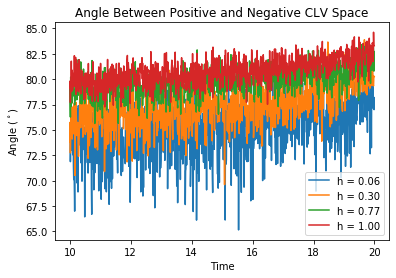

In [159]:
for i, angle in enumerate(angles):
    h = processedData[i].attrs['h']
    plt.plot(time, np.rad2deg(angle), label = f'h = {h:.2f}')

plt.legend()
plt.title('Angle Between Positive and Negative CLV Space')
plt.xlabel('Time')
plt.ylabel('Angle ($^\\circ$)')
plt.savefig('Effect-of-Coupling-Time-Series.png', dpi=1200)

### Density of Angle for Varying $h$

Below is a plot of the angle between the positive and negative CLVs.

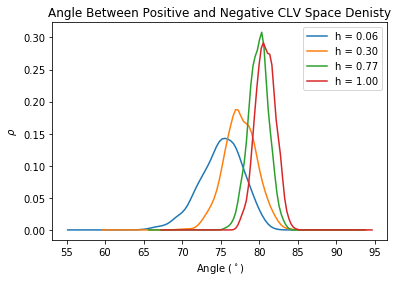

In [158]:
for i, angle in enumerate(angles):
    angle = np.rad2deg(angle)
    x_d = np.linspace(min(angle) - 10, max(angle) + 10, 100) # Grid we evaluate PDF on
    kde = gaussian_kde(angle) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
    pdf = kde.evaluate(x_d)
    h = processedData[i].attrs['h']
    label = f'h = {h:.2f}'
    plt.plot(x_d, pdf, label = label) 
plt.legend()
plt.title('Angle Between Positive and Negative CLV Space Denisty')
plt.xlabel('Angle ($^\\circ$)')
plt.ylabel('$\\rho$')
plt.savefig('Effect-of-Coupling-Density.png', dpi=1200)

### Effect of $h$ on the Spectra

Want to see if $h$ efeccts the number of near $0$ LEs.

In [2]:
for data in processedData:
    h = data.attrs['h']
    plt.plot(data.CLE, label = f'h = {h:.2f}')
plt.title('CLE Spectra')
plt.legend()
plt.xlabel('LE Index')
plt.ylabel('$\\lambda_C$')
#plt.savefig('CLE-Spectra.png', dpi=1200)
plt.figure()
for data in processedData:
    h = data.attrs['h']
    plt.plot(data.BLE, label = f'h = {h:.2f}')
plt.title('BLE Spectra')
plt.legend()
plt.xlabel('LE Index')
plt.ylabel('$\\lambda_B$')
#plt.savefig('BLE-Spectra.png', dpi=1200)

NameError: name 'processedData' is not defined

### BLV Sanity Check

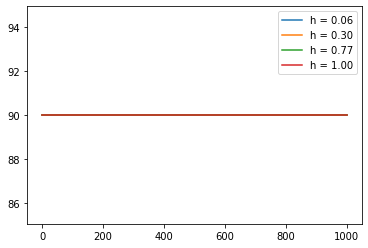

In [135]:
for i, angle in enumerate(bangles):
    h = processedData[i].attrs['h']
    plt.plot(np.rad2deg(angle), label = f'h = {h:.2f}')

plt.legend()

h = 0.0625, kd = 124.

h = 0.3, kd = 126.

h = 0.77, kd = 149.

h = 1, kd = 167.



Text(0.5, 1.0, 'Index of Smallest Positive CLE')

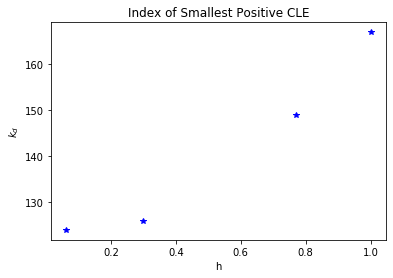

In [145]:
# Quick look at how the max positive LE indexchanges
for data in processedData:
    h, kd = data.attrs['h'], data.kd
    plt.plot(h, kd, '*b')
    print(f'h = {h}, kd = {kd}.\n')
plt.xlabel('h')
plt.ylabel('$k_d$')
plt.title('Index of Smallest Positive CLE')

### Quick Look at a Longer Run

In [4]:
directory = 'Data'
long_run_data = xr.open_dataset('L96_Long_Run.nc')

In [6]:
processed_long = processData(long_run_data)

In [8]:
langles = angle_calculator(processed_long.samples.CLV, processed_long.kd)

Calculating Angle Time Series


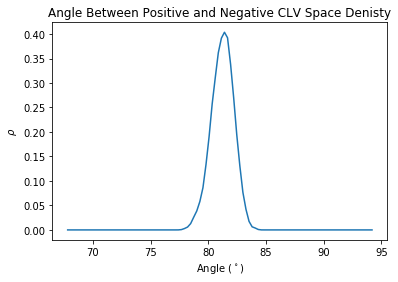

1


In [12]:
angle = np.rad2deg(langles)
x_d = np.linspace(min(angle) - 10, max(angle) + 10, 100) # Grid we evaluate PDF on
kde = gaussian_kde(angle) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
pdf = kde.evaluate(x_d)
plt.plot(x_d, pdf) 
plt.title('Angle Between Positive and Negative CLV Space Denisty')
plt.xlabel('Angle ($^\\circ$)')
plt.ylabel('$\\rho$')
plt.show()
print(processed_long.attrs['h'])